#### Loading saved data from joblib

In [92]:
import os
import joblib

In [ ]:
folder = r'C:/Users/FFFO CASHIER PT/OneDrive\Desktop/Mini Capstone project/database'
print( os.listdir(folder))

['WBTC_dune_data.pkl', 'WBTC_mcaps.pkl', 'WBTC_prices.pkl', 'WBTC_total_volumes.pkl']


In [94]:
# Load price data from joblib file

df_price = joblib.load(r'C:/Users/FFFO CASHIER PT/OneDrive/Desktop/Mini Capstone project/database/WBTC_prices.pkl')

print(df_price.keys())  


Index(['timestamp', 'price'], dtype='object')


In [95]:
# Load whale transfer data from joblib file
df_whale = joblib.load(r'C:/Users/FFFO CASHIER PT/OneDrive/Desktop/Mini Capstone project/database/WBTC_dune_data.pkl')

print(df_whale.keys())

Index(['receiver', 'sender', 'time', 'usd_value', 'date'], dtype='object')


### WBTC Whale Transfer

In [96]:
# Count the number of unique wallets (senders and receivers) per day

unique_senders_per_day = df_whale.groupby('date')['sender'].nunique()
unique_receivers_per_day = df_whale.groupby('date')['receiver'].nunique()

# Combining the result of unique senders and receivers into one DataFrame
unique_wallets_per_day = pd.DataFrame({
    'unique_senders': unique_senders_per_day,
    'unique_receivers': unique_receivers_per_day
})

print(unique_wallets_per_day.head())

            unique_senders  unique_receivers
date                                        
2025-05-13             205               188
2025-05-14             253               241
2025-05-15             306               289
2025-05-16             244               244
2025-05-17             188               188


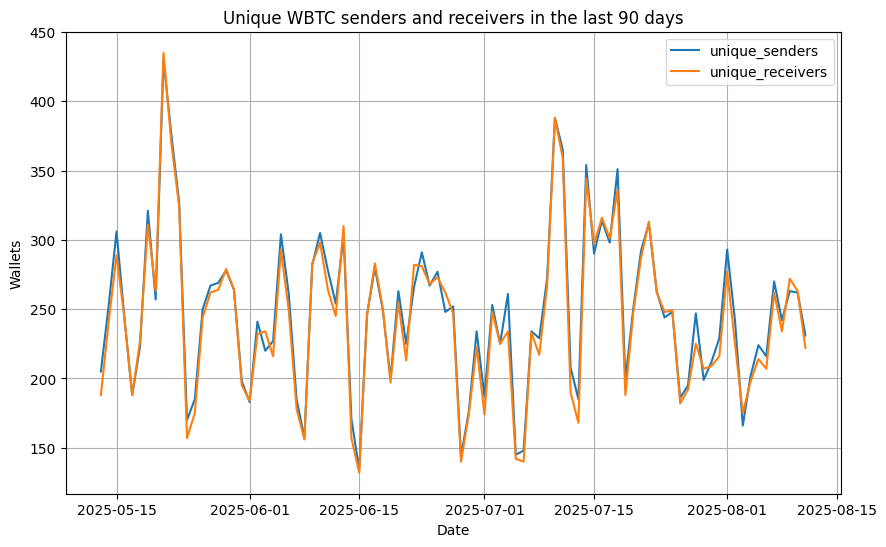

In [97]:
import matplotlib.pyplot as plt

unique_wallets_per_day.plot(kind='line', figsize=(10,6))

plt.title('Unique WBTC senders and receivers in the last 90 days')
plt.ylabel('Wallets')
plt.xlabel('Date')
plt.grid(True)
plt.show()

### WBTC Price Data (df_price)

In [124]:
# Convert price 'timestamp' column to datetime 

df_price['timestamp'] = pd.to_datetime(df_price['timestamp'])

# Extract date from time (drop time part)

df_price['date'] = df_price['timestamp'].dt.date  

print(df_price)

             timestamp          price        date
0  2025-05-14 00:00:00  104027.604301  2025-05-14
1  2025-05-15 00:00:00  103322.543852  2025-05-15
2  2025-05-16 00:00:00  103538.564610  2025-05-16
3  2025-05-17 00:00:00  103475.373775  2025-05-17
4  2025-05-18 00:00:00  103069.835724  2025-05-18
..                 ...            ...         ...
86 2025-08-08 00:00:00  117416.219528  2025-08-08
87 2025-08-09 00:00:00  116661.403500  2025-08-09
88 2025-08-10 00:00:00  116476.246985  2025-08-10
89 2025-08-11 00:00:00  119130.566226  2025-08-11
90 2025-08-11 16:34:07  120483.005807  2025-08-11

[91 rows x 3 columns]


### Load & Prepare Whale Data (df_whale)

### Merging Price movement and Whale Activity

In [126]:
# Checking for the unique dates in both dataframes

print(df_price['date'].min(), "to", df_price['date'].max())
print(df_whale['date'].min(), "to", df_whale['date'].max())


2025-05-14 to 2025-08-11
2025-05-13 to 2025-08-11


In [144]:
# Merge price into whale transactions

merged_df_prices_whale = pd.merge(df_whale, df_price[['date', 'price']], on='date', how='left')

print(merged_df_prices_whale.head())

                                     receiver  \
0  0x28c6c06298d514db089934071355e5743bf21d60   
1  0x28c6c06298d514db089934071355e5743bf21d60   
2  0x9008d19f58aabd9ed0d60971565aa8510560ab41   
3  0x9008d19f58aabd9ed0d60971565aa8510560ab41   
4  0xa69babef1ca67a37ffaf7a485dfff3382056e78c   

                                       sender                      time  \
0  0xeae7380dd4cef6fbd1144f49e4d1e6964258a4f4 2025-08-11 13:09:59+00:00   
1  0xeae7380dd4cef6fbd1144f49e4d1e6964258a4f4 2025-08-11 13:09:59+00:00   
2  0xb3251d56bf27864f04f315d38dd7f1296ac4a727 2025-08-11 13:09:47+00:00   
3  0xb3251d56bf27864f04f315d38dd7f1296ac4a727 2025-08-11 13:09:47+00:00   
4  0x9008d19f58aabd9ed0d60971565aa8510560ab41 2025-08-11 13:09:47+00:00   

       usd_value        date          price  
0  524032.939100  2025-08-11  119130.566226  
1  524032.939100  2025-08-11  120483.005807  
2  681980.816776  2025-08-11  119130.566226  
3  681980.816776  2025-08-11  120483.005807  
4  681979.124114  2025-0

In [163]:
threshold_usd = 100000

# Filter whale transactions (>= threshold)
df_whales = merged_df_prices_whale[merged_df_prices_whale['usd_value'] >= threshold_usd]

# Group by date and aggregate both sum of usd_value and count of transactions
whale_stats = df_whales.groupby('date').agg(
    whale_volume=('usd_value', 'sum'),
    whale_count=('usd_value', 'size'),
    price=('price', 'first') 
).reset_index()

print(whale_stats)


          date  whale_volume  whale_count          price
0   2025-05-13  8.506822e+08          845            NaN
1   2025-05-14  1.056095e+09         1293  104027.604301
2   2025-05-15  9.897261e+08         1392  103322.543852
3   2025-05-16  7.330400e+08         1027  103538.564610
4   2025-05-17  9.744010e+08          777  103475.373775
..         ...           ...          ...            ...
86  2025-08-07  2.007615e+09          929  114941.388357
87  2025-08-08  3.300521e+09          744  117416.219528
88  2025-08-09  3.187607e+09         1673  116661.403500
89  2025-08-10  2.273828e+09         1133  116476.246985
90  2025-08-11  9.967208e+09         2088  119130.566226

[91 rows x 4 columns]


In [164]:
df_merged = whale_stats.sort_values('date')
df_merged['price_change_pct'] = df_merged['price'].pct_change() * 100

print(df_merged)


          date  whale_volume  whale_count          price  price_change_pct
0   2025-05-13  8.506822e+08          845            NaN               NaN
1   2025-05-14  1.056095e+09         1293  104027.604301               NaN
2   2025-05-15  9.897261e+08         1392  103322.543852         -0.677763
3   2025-05-16  7.330400e+08         1027  103538.564610          0.209074
4   2025-05-17  9.744010e+08          777  103475.373775         -0.061031
..         ...           ...          ...            ...               ...
86  2025-08-07  2.007615e+09          929  114941.388357          0.731666
87  2025-08-08  3.300521e+09          744  117416.219528          2.153124
88  2025-08-09  3.187607e+09         1673  116661.403500         -0.642855
89  2025-08-10  2.273828e+09         1133  116476.246985         -0.158713
90  2025-08-11  9.967208e+09         2088  119130.566226          2.278850

[91 rows x 5 columns]


## Data Visualization

#### Correlation Analysis:

This is to check if whale volume or count correlates with price change

In [166]:
correlation_volume = df_merged['whale_volume'].corr(df_merged['price_change_pct'])
correlation_count = df_merged['whale_count'].corr(df_merged['price_change_pct'])

print(f"Correlation (whale volume vs price change): {correlation_volume:.4f}")
print(f"Correlation (whale count vs price change): {correlation_count:.4f}")


Correlation (whale volume vs price change): 0.0344
Correlation (whale count vs price change): 0.1585


#### Correlation analysis result:

- Whale volume vs. price change: 0.0344

- Whale count vs. price change: 0.1585

These values suggest: 

That whale transaction volume or count don't have a strong linear relationship with price change

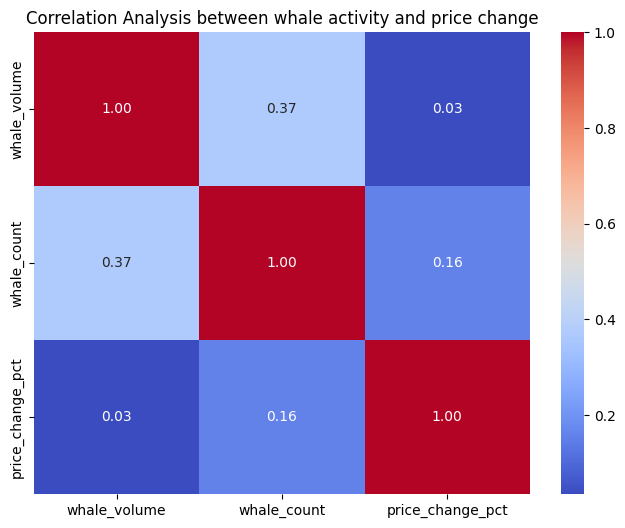

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

# Subset of relevant columns
corr = df_merged[['whale_volume', 'whale_count', 'price_change_pct']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Analysis between whale activity and price change")
plt.show()


#### Lag Analysis:

This helps test if whale activity leads price changes (that is, shift in whale activity by 1 day)

In [169]:
df_merged['whale_volume_lag1'] = df_merged['whale_volume'].shift(1)
df_merged['whale_count_lag1'] = df_merged['whale_count'].shift(1)

corr_lag_volume = df_merged['whale_volume_lag1'].corr(df_merged['price_change_pct'])
corr_lag_count = df_merged['whale_count_lag1'].corr(df_merged['price_change_pct'])

print(f"Lag-1 Correlation (whale volume -> next day price change): {corr_lag_volume:.4f}")
print(f"Lag-1 Correlation (whale count -> next day price change): {corr_lag_count:.4f}")


Lag-1 Correlation (whale volume -> next day price change): 0.0156
Lag-1 Correlation (whale count -> next day price change): 0.0858


#### Lag Analysis result:

Lagging whale activity by 1 day, answers the question: 

- Does today's whale activity affects tomorrow's price movement 

There's no strong evidence that whale behavior directly or immediately influences price movements on a daily timescale, at least not linearly.

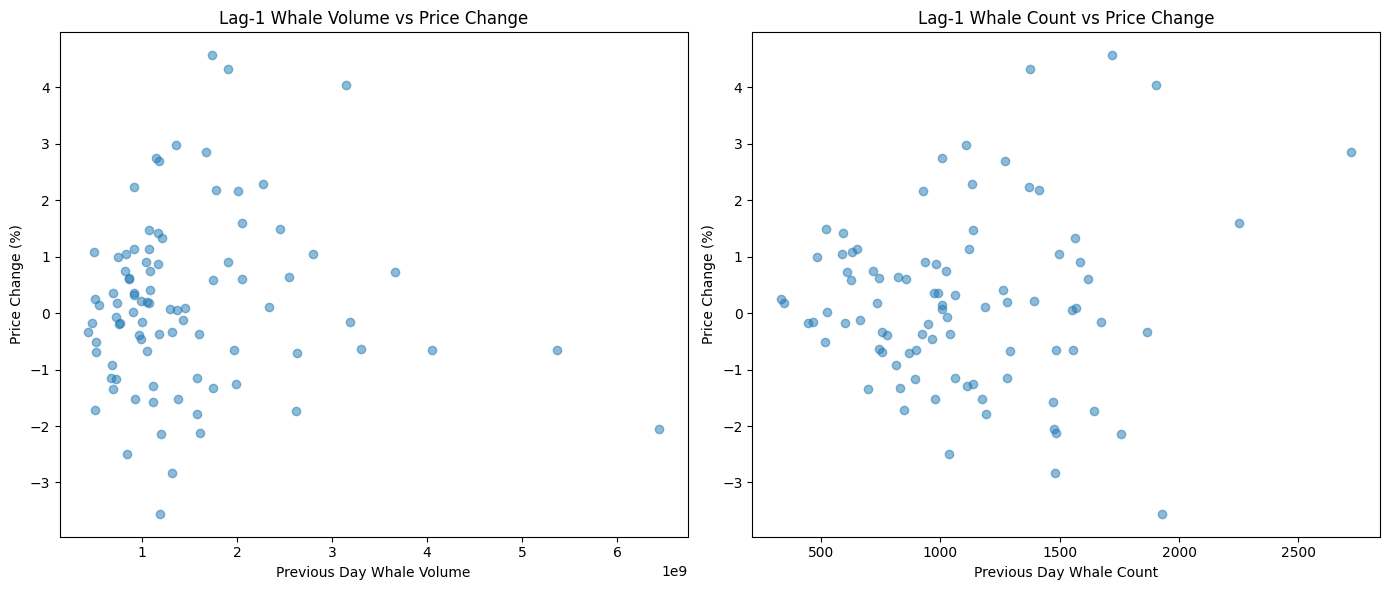

In [170]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Lag-1 Whale Volume vs Price Change
plt.subplot(1, 2, 1)
plt.scatter(df_merged['whale_volume_lag1'], df_merged['price_change_pct'], alpha=0.5)
plt.title('Lag-1 Whale Volume vs Price Change')
plt.xlabel('Previous Day Whale Volume')
plt.ylabel('Price Change (%)')

# Lag-1 Whale Count vs Price Change
plt.subplot(1, 2, 2)
plt.scatter(df_merged['whale_count_lag1'], df_merged['price_change_pct'], alpha=0.5)
plt.title('Lag-1 Whale Count vs Price Change')
plt.xlabel('Previous Day Whale Count')
plt.ylabel('Price Change (%)')

plt.tight_layout()
plt.show()


#### Dual - axis plotting in Matplotlib and Seaborn

##### Price vs Whale Volume

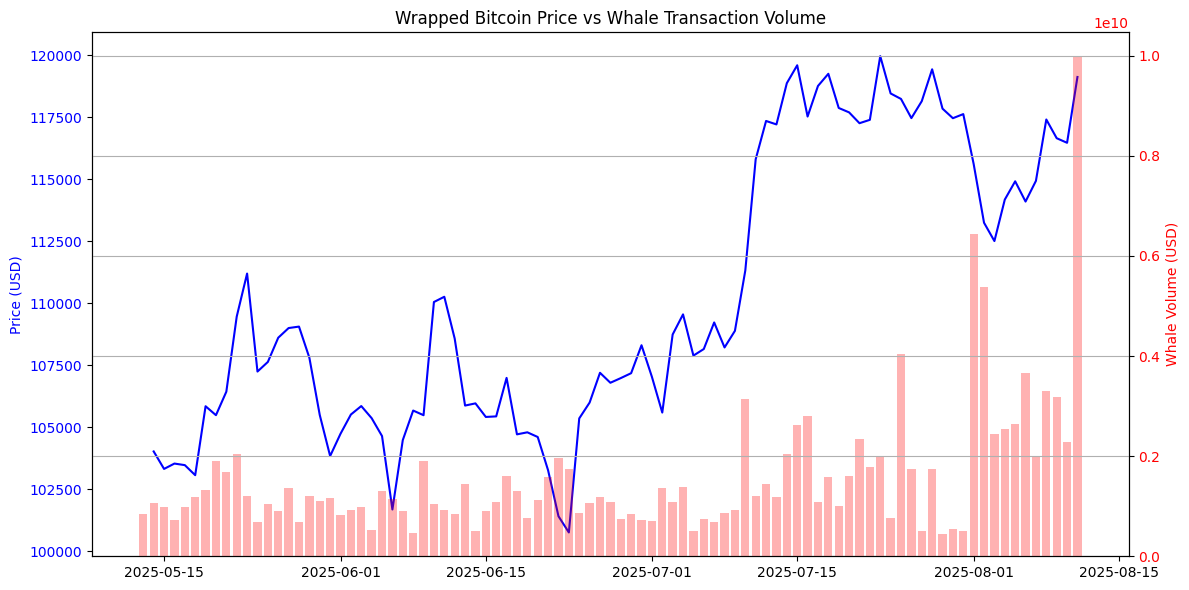

In [171]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df_merged['date'], df_merged['price'], color='blue', label='Price (USD)')
ax1.set_ylabel('Price (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.bar(df_merged['date'], df_merged['whale_volume'], color='red', alpha=0.3, label='Whale Volume')
ax2.set_ylabel('Whale Volume (USD)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Wrapped Bitcoin Price vs Whale Transaction Volume')
plt.grid(True)
plt.tight_layout()
plt.show()


##### The chart shows a dual-axis time series comparing Price vs Whale Volume:

- Left Y-Axis (Blue Line): Wrapped Bitcoin Price (USD) over time

    - This is a line plot showing how the price changes per day

- Right Y-Axis (Red Bars): Whale Transaction Volume (USD) over time

    - The bars represents the daily whale activity, over $100K per transaction

    This plot shows two key metrics over time related to Wrapped Bitcoin (WBTC):

From this plot, some large whale transaction days happened around both high and low price points, so the relationship between WBTC price change and volume is weak.



##### Calculate Price Volatility

In [173]:
# Calculate daily returns (percentage change)
df_merged['price_return'] = df_merged['price'].pct_change()

# Calculate rolling volatility - e.g., 7-day rolling std dev of returns
df_merged['volatility_7d'] = df_merged['price_return'].rolling(window=7).std() * 100  # in percent

print(df_merged[['date', 'price_return', 'volatility_7d']].tail(10))


          date  price_return  volatility_7d
81  2025-08-02     -0.020501       1.203193
82  2025-08-03     -0.006523       1.101972
83  2025-08-04      0.014861       1.213544
84  2025-08-05      0.006462       1.254125
85  2025-08-06     -0.007106       1.261196
86  2025-08-07      0.007317       1.322252
87  2025-08-08      0.021531       1.447009
88  2025-08-09     -0.006429       1.143508
89  2025-08-10     -0.001587       1.079030
90  2025-08-11      0.022789       1.230640


##### Adding lagged whale activity features (to test if whales lead volatility)

In [175]:
# Lag whale_volume and whale_count by 1 day

df_merged['whale_volume_lag1'] = df_merged['whale_volume'].shift(1)
df_merged['whale_count_lag1'] = df_merged['whale_count'].shift(1)


#### Correlation between lagged whale activity and volatility

In [176]:
corr_vol_lag_volume = df_merged['whale_volume_lag1'].corr(df_merged['volatility_7d'])
corr_vol_lag_count = df_merged['whale_count_lag1'].corr(df_merged['volatility_7d'])

print(f"Lag-1 Correlation (whale volume -> volatility): {corr_vol_lag_volume:.4f}")
print(f"Lag-1 Correlation (whale count -> volatility): {corr_vol_lag_count:.4f}")


Lag-1 Correlation (whale volume -> volatility): -0.1957
Lag-1 Correlation (whale count -> volatility): 0.0663


##### Lag-1 Correlation Results (Whale Activity -> Next Day Volatility)
- Whale volume → volatility: -0.1957

    This implies that a higher whale volume on a given day does not predict higher volatility the next day

- Whale count → volatility:  0.0663
    This may indicate a small tendency that increased whale activity (number of transactions) can precede minor increase in volatility the next day.

##### Whale Activity vs. Volatility

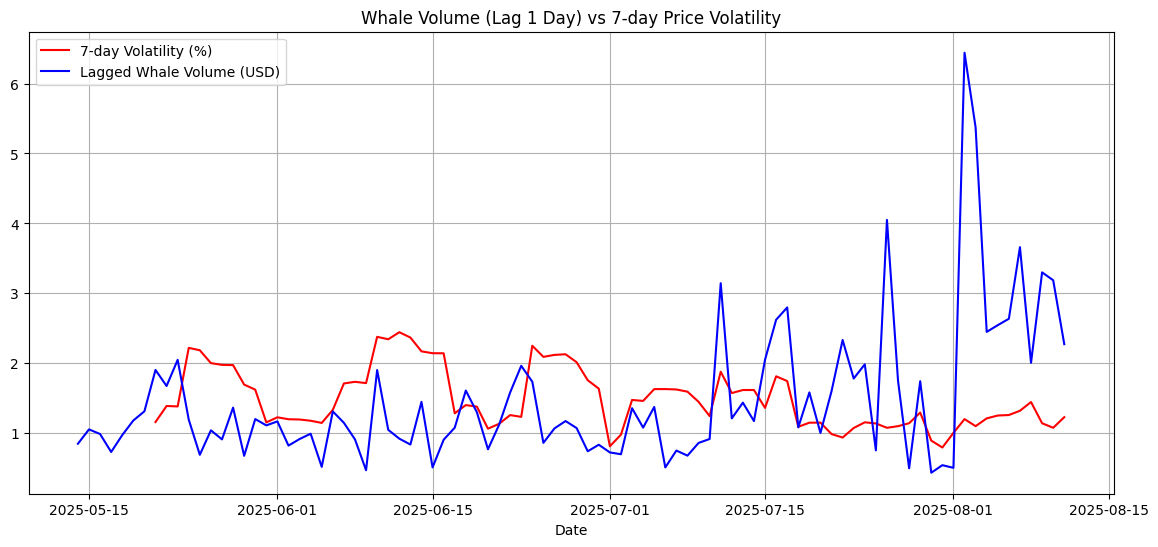

In [178]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.plot(df_merged['date'], df_merged['volatility_7d'], label='7-day Volatility (%)', color='red')
plt.plot(df_merged['date'], df_merged['whale_volume_lag1'] / 1e9, label='Lagged Whale Volume (USD)', color='blue')
plt.xlabel('Date')
plt.title('Whale Volume (Lag 1 Day) vs 7-day Price Volatility')
plt.legend()
plt.grid(True)
plt.show()


##### Whale Volume (Lag 1 Day) vs 7-Day Price Volatility
This means that whale volume from the previous day doesn’t significantly predict or precede 7-day price volatility.
 
 Both Visual insights and correlation analysis agrees, that whale activity alone is not a good short-term volatility signal.

The blue line (lagged whale volume) shows quite a few spikes that those whale transactions are quite volatile themselves.

The red line (volatility) is smoother, but there are some period where volatility increases, sometimes near spikes in whale volume.

Sometimes whale spikes precede dips in volatility.
